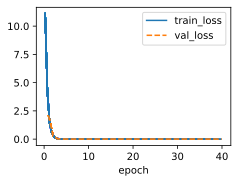

In [123]:
import torch
import random
import inspect
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import collections
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

def to_numpy(tensor):
    if tensor.requires_grad:
        return tensor.detach().numpy()
    else:
        return tensor.numpy()

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class DataModule(HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = TensorDataset(*tensors)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=train)

class SyntheticRegressionData(DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

    def get_dataloader(self, train=True):
        indices = list(range(0, self.num_train)) if train else list(range(self.num_train, self.num_train + self.num_val))
        random.shuffle(indices)  # Shuffle only if it's training data
        for i in range(0, len(indices), self.batch_size):
            batch_indices = torch.tensor(indices[i: i + self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    def has_one_axis(X):  # True if X (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None:
        axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        x = to_numpy(x)
        y = to_numpy(y)
        axes.plot(x, y, fmt) if len(x) else axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        """Plot a point in animation."""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

class Module(nn.Module, HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch
        self.board.draw(x, to_numpy(value), ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

class LinearRegressionScratch(Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = nn.Parameter(torch.normal(0, sigma, (num_inputs, 1)))
        self.b = nn.Parameter(torch.zeros(1))
        self.lr = lr

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def training_step(self, batch):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.plot('loss', loss, train=True)
        return loss

    def validation_step(self, batch):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.plot('loss', loss, train=False)
        return loss

class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = list(data.train_dataloader())
        self.val_dataloader = list(data.val_dataloader())
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = len(self.val_dataloader)

    def prepare_model(self, model):
        model.trainer = self
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            self.train_batch_idx += 1

        if self.val_dataloader is None:
            return

        self.model.eval()
        with torch.no_grad():
            for batch in self.val_dataloader:
                self.model.validation_step(batch)
                self.val_batch_idx += 1

if __name__ == "__main__":
    # Model parameters
    w_true = torch.tensor([2.0, -3.4])
    b_true = 4.2
    num_inputs = 2
    lr = 0.03

    # Initialize model, optimizer, and data
    model = LinearRegressionScratch(num_inputs, lr)
    data = SyntheticRegressionData(w_true, b_true)
    trainer = Trainer(max_epochs=40)

    # Fit the model
    trainer.fit(model, data)


In [47]:
import torch
import random
import inspect
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import collections
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
import numpy as np


# HyperParameter Class

In [40]:
import inspect
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams  = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')} 
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [41]:
class TestModel(HyperParameters):
    def __init__(self, learning_rate, batch_size, epochs):
        self.save_hyperparameters()

In [42]:
model = TestModel(learning_rate = 0.05, batch_size = 32, epochs = 3)

In [43]:
print("Saved hyperparameters:", model.hparams)
print("Model attributes:")
print(f"learning_rate: {model.learning_rate}")
print(f"batch_size: {model.batch_size}")
print(f"epochs: {model.epochs}")

Saved hyperparameters: {'learning_rate': 0.05, 'batch_size': 32, 'epochs': 3}
Model attributes:
learning_rate: 0.05
batch_size: 32
epochs: 3


### Module Class

In [53]:
class Module(nn.Module, HyperParameter):
    """
    The base class for models.
    """
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
    def loss (self, X, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
    
    def validation_step(self, batch):
         l = self.loss(self(*batch[:-1]), batch[-1])

    def configure_optimizers(self):
        raise NotImplementedError

In [56]:
class TestNet(Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(10,1)

    def loss(self, X, y):
        return nn.MSELoss()(X,y)

    def configure_optimizer(self):
        return torch.optim.SGD(self.parameters(), lr = 0.01)
    

In [72]:
output = model(X)
print(model.hparams)
X = torch.randn(5, 10)
output = model(X)

{'plot_train_per_epoch': 2, 'plot_valid_per_epoch': 1}


In [74]:
class DataModule(HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [76]:
class Trainer(HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError